In [2]:
import os
import pandas as pd
import numpy as np
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import codecs
import tensorflow_hub as hub
import keras.backend as K
import gensim
import gc
import random
from torch.optim import lr_scheduler
import time
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

path='drive/My Drive/Advanced_NLP/Week 4 - RNNs  and LSTMs/'

In [72]:
train_data=pd.read_csv(path+'train.tsv',sep='\t',header=None)
valid_data=pd.read_csv(path+'valid.tsv',sep='\t',header=None)
test_data=pd.read_csv(path+'test.tsv',sep='\t',header=None)

columns=['id','label','statement','subject','speaker','speaker_job','state','party','barelytrue_counts','false_counts','halftrue_counts','mostlytrue_counts',
              'pantsonfire_counts','statement_loc']

train_data=pd.concat([train_data,valid_data],axis=0).reset_index(drop=True)

train_data.columns=columns
test_data.columns=columns

### Data exploration

In [73]:
train_data.head(3)

,id,label,statement,subject,speaker,speaker_job,state,party,barelytrue_counts,false_counts,halftrue_counts,mostlytrue_counts,pantsonfire_counts,statement_loc
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [74]:
train_data['label'].value_counts()

half-true      2362
false          2258
mostly-true    2213
barely-true    1891
true           1845
pants-fire      955
Name: label, dtype: int64

In [75]:
train_data.isna().sum()

id                       0
label                    0
statement                0
subject                  2
speaker                  2
speaker_job           3242
state                 2487
party                    2
barelytrue_counts        2
false_counts             2
halftrue_counts          2
mostlytrue_counts        2
pantsonfire_counts       2
statement_loc          114
dtype: int64

In [76]:
train_data=train_data.dropna(subset=['subject'])
train_data=train_data.fillna('NA')
train_data=train_data.reset_index(drop=True)

test_data=test_data.dropna(subset=['subject'])
test_data=test_data.fillna('NA')
test_data=test_data.reset_index(drop=True)

In [77]:
# using all labels as such has no pattern and the model is struggling to learn, hence binning them to 3 categories
di = {"false":0,"half-true":1,"mostly-true":1,"true":1,"barely-true":0,"pants-fire":2} 

train_data['label']=train_data['label'].map(di)
test_data['label']=test_data['label'].map(di)

In [78]:
train_data.groupby('state').agg({'barelytrue_counts':['sum', 'mean'], 
                         'false_counts':['sum', 'mean'], 
                         'halftrue_counts':['sum', 'mean'], 
                         'mostlytrue_counts': ['sum', 'mean']}).reset_index()

state barelytrue_counts  ... mostlytrue_counts           
                                    sum  ...               sum       mean
0             Alabama              15.0  ...               7.0   0.437500
1              Alaska             536.0  ...             354.0   4.849315
2             Arizona            5232.0  ...            6255.0  30.661765
3            Arkansas             677.0  ...             587.0   6.114583
4             Atlanta               0.0  ...               1.0   1.000000
..                ...               ...  ...               ...        ...
81          Wisconsin            7329.0  ...            9209.0  11.525657
82         Wisconsin                0.0  ...               0.0   0.000000
83            Wyoming               2.0  ...               0.0   0.000000
84               ohio               2.0  ...               2.0   1.000000
85  the United States               1.0  ...               0.0   0.000000

[86 rows x 9 columns]

167.0


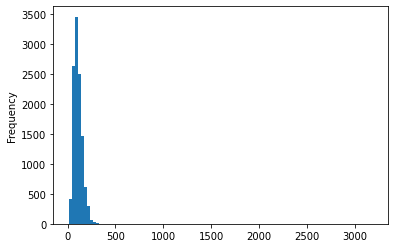

In [79]:
train_data['len'] = train_data['statement'].apply(lambda s : len(s))
train_data['len'].plot.hist(bins=100)
print(train_data.len.quantile(0.9)) #average doc len to consider

45.0


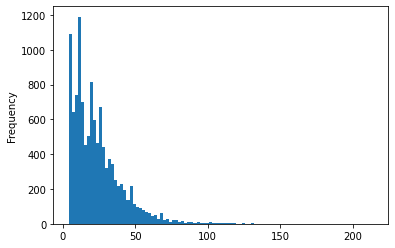

In [80]:
train_data['subject_len'] = train_data['subject'].apply(lambda s : len(s))
train_data['subject_len'].plot.hist(bins=100)
print(train_data.subject_len.quantile(0.9)) #average subject len to consider

### Data processing

In [81]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\n', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' ')
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

In [82]:
train_data = clean_data(train_data, ['statement', 'subject'])
test_data = clean_data(test_data, ['statement', 'subject'])

### Loading embedding matrix

In [83]:
def load_glove_model(glove_file):
  """
  :param glove_file: embeddings_path: path of glove file.
  :return: glove model
  """
  embeddings_index = {}
  with open(glove_file,'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  
  print('Found %s word vectors.' % len(embeddings_index))

  return embeddings_index


def build_matrix(embedding_path: str = '',
                 word_dict: dict = None, max_features: int = 100000,
                 embed_size: int= 300):

    embedding_index = load_glove_model(embedding_path)

    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    unknown_words = []
    for word, i in word_dict.items():
        key = word
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.lower())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embedding_index.get(word.capitalize())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        unknown_words.append(key)

    print(f'{len(unknown_words) * 100 / len(word_dict):.4f}% words are not in embeddings')
    return embedding_matrix, nb_words, unknown_words


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [84]:
tokenizer = Tokenizer()
full_text = list(train_data['statement']) + \
                       list(test_data['statement'])
tokenizer.fit_on_texts(full_text)

In [85]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip
# !cp 'drive/My Drive/glove.6B.300d.txt' path

In [17]:
embedding_matrix, nb_words, unknown_words = build_matrix('drive/My Drive/glove.6B.300d.txt', tokenizer.word_index,
                                              100000, 300)

Found 400000 word vectors.
5.3549% words are not in embeddings


In [18]:
!python -m gensim.scripts.glove2word2vec --input  'drive/My Drive/glove.6B.300d.txt' --output 'glove.6B.300d.w2vformat.txt'

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'gensim.scripts.glove2word2vec' found in sys.modules after import of package 'gensim.scripts', but prior to execution of 'gensim.scripts.glove2word2vec'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2020-09-20 16:35:54,395 - glove2word2vec - INFO - running /usr/local/lib/python3.6/dist-packages/gensim/scripts/glove2word2vec.py --input drive/My Drive/glove.6B.300d.txt --output glove.6B.300d.w2vformat.txt
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-09-20 16:35:55,584 - glove2word2vec - INFO - converting 400000 vectors from drive/My Drive/glove.6B.300d.txt to glove.6B.300d.w2vformat.txt
2020-09-20 16:35:59

In [19]:
model = gensim.models.KeyedVectors.load_word2vec_format('glove.6B.300d.w2vformat.txt')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

def get_embedding_features(train, test, col,model):

    embedding_train = {}
    embedding_test = {}

    train_text = train[col].tolist()
    test_text = test[col].tolist()

    curr_train_emb = []
    curr_test_emb = []

    for subj in train_text:
      curr_train_emb.append(document_vector(model,subj))

    for subj in test_text:
      curr_test_emb.append(document_vector(model,subj))
       
    embedding_train['subj_embedding'] = np.vstack(curr_train_emb)
    embedding_test['subj_embedding'] = np.vstack(curr_test_emb)

    gc.collect()
    
    return embedding_train, embedding_test

In [21]:
#average embeddings for subject
embedding_train,embedding_test = get_embedding_features(train_data, test_data,'subject',model)

In [22]:
#other meta features
meta_cols=['barelytrue_counts',
       'false_counts', 'halftrue_counts', 'mostlytrue_counts',
       'pantsonfire_counts']

credit_scores_train=train_data[meta_cols].values
credit_scores_test=test_data[meta_cols].values

In [125]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = F.softmax(y_pred, dim = 1)
    y_pred_tags = torch.argmax(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

# training the model

def train_model(model, train_loader, valid_loader, n_epochs=5, lr=0.001):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    patience = 2

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1)
    
    loss_fn = nn.CrossEntropyLoss().cuda()
    best_score = 0

    for epoch in range(n_epochs):
      
        start_time = time.time()
        model.train()
        avg_loss = 0.

        for data in tqdm(train_loader, disable=True):
            statement = data['statement'].cuda()
            subject = data['subject'].cuda()
            scores = data['scores'].cuda()
            
            y_batch = data['target'].cuda()
            y_pred = model(statement, subject, scores)

            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)

        model.eval()

        avg_val_loss = 0.
        score = 0
      
        for data in valid_loader:
            statement = data['statement'].cuda()
            subject = data['subject'].cuda()
            scores = data['scores'].cuda()
            
            y_batch = data['target'].cuda()
            y_pred = model(statement, subject, scores).detach()

            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
      
            score += multi_acc(y_pred, y_batch).item() / len(valid_loader)
            

        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t acc={:.2f}'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, score))

        scheduler.step(avg_val_loss)

        valid_score = score
        if valid_score > best_score:
            best_score = valid_score
            p = 0
            torch.save(model.state_dict(), 'model.pt')

        # check if validation loss didn't improve
        if valid_score <= best_score:
            p += 1
            print(f'{p} epochs of non improving score')
            if p > patience:
                print('Stopping training')
                stop = True
                break
                
        model.load_state_dict(torch.load('model.pt'))
                
    return model


def make_prediction(test_loader: DataLoader = None, model = None):
    prediction = np.zeros(len(test_loader.dataset))
    model.eval()
    for i,data in enumerate(test_loader):

        start_index = i * test_loader.batch_size
        end_index   = min(start_index + test_loader.batch_size, len(test_loader.dataset))
        statement = data['statement'].cuda()
        subject = data['subject'].cuda()
        scores = data['scores'].cuda()


        y_pred = model(statement, subject, scores).detach()
        y_pred_softmax = F.softmax(y_pred, dim = 1)
        y_pred_tags = torch.argmax(y_pred_softmax, dim = 1)  
      
        prediction[start_index:end_index] +=  y_pred_tags.cpu().numpy()
        
    return prediction

In [126]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

class hybrid_model(nn.Module):
    def __init__(self,
                 hidden_size: int = 128,
                 embedding_matrix=None,
                 no_of_classes: int = 3):
        super(hybrid_model, self).__init__()

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.embedding_dropout = SpatialDropout(0.3)
        self.class_labels=no_of_classes


        self.lstm_q = nn.LSTM(300, hidden_size, bidirectional=True, batch_first=True)
        self.gru_q = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.linear1 = nn.Sequential(nn.Linear(512 +200,300),
                                     nn.BatchNorm1d(300),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(0.5))


        self.linear2 = nn.Sequential(nn.Linear(305,200),
                                     nn.BatchNorm1d(200),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(0.5))

        self.classifier = nn.Linear(300, self.class_labels)

    def forward(self,statement,subj,meta):

        #get embedding of statement and pass through different rnn layers
        statement_embedding = self.embedding(statement)
        statement_embedding = self.embedding_dropout(statement_embedding)

        h_lstm_s, _ = self.lstm_q(statement_embedding)
        h_gru_s, _ = self.gru_q(h_lstm_s)


        avg_pool_s = torch.mean(h_gru_s, 1)
        max_pool_s, _ = torch.max(h_gru_s, 1)

        #concatenate meta features,normalise and pass them through linear layer
        meta_feat=torch.cat((subj,meta), 1)
        agg_feat=torch.cat((avg_pool_s,max_pool_s),1)

        meta_linear=self.linear2(meta_feat)

        out=self.linear1(torch.cat((agg_feat, meta_linear), 1))

        logits=self.classifier(out)

        return logits

In [116]:
seed_everything()

In [117]:
train_statement_tokenized = pad_sequences(tokenizer.texts_to_sequences(train_data['statement']), maxlen = 170)
test_statement_tokenized = pad_sequences(tokenizer.texts_to_sequences(test_data['statement']), maxlen = 170)

In [118]:
y_train=train_data['label'].values
y_valid=test_data['label'].values

### Dataset class

In [127]:
class TextDataset(Dataset):

    def __init__(self, statement, subj_embeddings,scores, idxs, targets=None):

        self.statement = statement[idxs]
        self.subj_embeddings = subj_embeddings['subj_embedding'][idxs]
        self.scores = scores[idxs]

        self.targets = targets[idxs] if targets is not None else np.zeros((self.statement.shape[0], 3))

    def __getitem__(self, idx):
        statement = self.statement[idx]
        subject = self.subj_embeddings[idx]
  
        scores = self.scores[idx]
        target = self.targets[idx]

        return {
            'statement': torch.tensor(statement, dtype=torch.long),
            'subject': torch.tensor(subject, dtype=torch.long),
            'scores': torch.tensor(scores, dtype=torch.float),
            'target': torch.tensor(target, dtype=torch.long),
        }

    def __len__(self):
        return len(self.statement)

In [128]:
bs_test = 16
bs_train=128

In [129]:
train_loader = DataLoader(TextDataset(train_statement_tokenized,embedding_train,credit_scores_train,train_data.index, y_train),
                              batch_size=bs_train, shuffle=True)

valid_loader = DataLoader(TextDataset(test_statement_tokenized,embedding_test,credit_scores_test, test_data.index,y_valid),
                          batch_size=bs_test, shuffle=False)
    
net = hybrid_model(embedding_matrix=embedding_matrix)
net.cuda()

net= train_model(net, train_loader, valid_loader, n_epochs=10, lr=0.001)
prediction = make_prediction(valid_loader, net)

gc.collect()
torch.cuda.empty_cache()
print()

Epoch 1/10 	 loss=0.9050 	 val_loss=0.7948 	 acc=71.25
1 epochs of non improving score
Epoch 2/10 	 loss=0.8352 	 val_loss=0.7829 	 acc=77.50
1 epochs of non improving score
Epoch 3/10 	 loss=0.8158 	 val_loss=0.7646 	 acc=77.50
2 epochs of non improving score
Epoch 4/10 	 loss=0.8182 	 val_loss=0.7748 	 acc=75.00
3 epochs of non improving score
Stopping training



In [113]:
prediction

array([1., 0., 0., ..., 1., 1., 1.])